# Anomaly Detection - Zelong
**Harvard University**<br>
**Fall 2016**<br>
**Instructors: W. Pan, P. Protopapas, K. Rader**<br>

<br>

**Dennis Milechin, Ivan Sunyagin, Hany Bassily**

Import libraries

In [64]:
import numpy as np
import pandas as pd
import scipy as sp
from cycler import cycler
from matplotlib.pyplot import cm 
import os
import time
from IPython.display import Image, display

import pydotplus
from IPython.display import Image
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("paper")
sns.set_palette("RdBu", n_colors=32)
from inspect import getmembers

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cmx
import matplotlib.colors as colors



import StringIO
import collections
from matplotlib import rcParams
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

**---**

In [2]:
# Removes missing values that are designated by a series of 9 values.
# Excerpt from NOAA Site: " Missing data in the Realtime files are denoted by "MM" 
#                    while a variable number of 9's are used to denote missing data in the
#                    Historical files, depending on the data type (for example: 999.0 99.0)."
# Input:
#      df = dataframe to be cleaned
# Return:
#      df = cleaned dataframe
def clean_data(df):

    for column in df.columns[1:]:

        max_val = df[column].max()

        if(max_val % 9 == 0):
            df.loc[df[column] == max_val, column] = None
    
    return df

In [3]:
# data values
buyo_ids = [41002, 41040, 41041, 41043, 41044, 41046, 41047, 41048, 41049, 42059]
startMonth = 1 # January
endMonth = 9 # September
totalMonths = 9
year = 2016

In [4]:
def read_month(id, month, year):
    dateparse = lambda x: pd.datetime.strptime(x, '%Y %m %d %H %M')
    
    path = '../BuoyData/{}/{}{}{}.txt'.format(id, id, month, year)
    df = pd.read_csv(path, 
                     delim_whitespace = True, 
                     skiprows = [1], 
                     parse_dates = {'DATETIME' : [0,1,2,3,4] },
                     date_parser=dateparse)
    df = clean_data(df)
    df['ID'] = id
    return df

def read_year(id, fromMonth, toMonth, year):
    
    bouy_data = []
    
    for month in range(fromMonth, toMonth + 1):
        bouy_data.append(read_month(id, month, year))
    
    return pd.concat(bouy_data)

In [5]:
def get_name(predictor):
    values = {
     'WDIR' : 'Wind Direction',
     'WSPD' : 'Wind Speed',
     'GST' : 'Gust Speed',
     'WVHT' : 'Wave Height',
     'DPD' : 'Dominant Wave Period',
     'APD' : 'Average Wave Period',
     'MWD' : 'DPD Direction',
     'PRES' : 'Sea Level Pressure',
     'ATMP' : 'Air Temperature',
     'WTMP' : 'Sea Surface Temperature',
     'DEWP' : 'Dewpoint Temperature',
     'VIS' : 'Station Visibility',
     'TIDE' : 'Water Level'
    }
    return values[predictor]

In [6]:
bs = { id : read_year(id, startMonth, endMonth, year) for id in buyo_ids }

In [7]:
# Concate all the data into one DataFrame
bouy_data = []

for id in buyo_ids:
    bouy_data.append(read_year(id, startMonth, endMonth, year))

bouy_data = pd.concat(bouy_data)

In [8]:
bouy_data.head()


,DATETIME,WDIR,WSPD,GST,WVHT,DPD,APD,MWD,PRES,ATMP,WTMP,DEWP,VIS,TIDE,ID
0,2015-12-31 23:50:00,225.0,8.2,10.1,1.65,5.88,5.45,184.0,NaN,24.4,25.0,21.9,NaN,NaN,41002
1,2016-01-01 00:50:00,218.0,8.5,10.3,1.53,5.88,5.26,173.0,NaN,24.3,25.0,21.9,NaN,NaN,41002
2,2016-01-01 01:50:00,218.0,8.8,10.4,1.60,5.56,5.43,198.0,NaN,24.2,24.9,21.8,NaN,NaN,41002
3,2016-01-01 02:50:00,220.0,8.7,10.6,1.71,5.88,5.44,180.0,NaN,24.3,24.9,22.1,NaN,NaN,41002
4,2016-01-01 03:50:00,232.0,10.2,12.0,1.69,5.88,5.38,199.0,NaN,24.5,24.9,21.4,NaN,NaN,41002


In [9]:
# Integral function to calculate the mixture Power Martingale:
# ------------------------------------------------------------

def trap_mix(m,e):
        
        diff = np.diff(m)
        diff =  np.append(diff, 0)

        b = np.add(m,diff)

        b = np.delete(b, len(b)-1)

        b = b*0.5

        h = np.diff(e)

        areas =  h*b

        integral = areas.sum()

        return integral
        

In [16]:
# Function to calculate Power Martingale:
# ---------------------------------------
def power_martingale(d):
    import numpy as np
    # grid resolution for mix integration
    res = 100

    # epsilon array
    eps = np.linspace(0.001, 0.999, res)
    
    # data mean
    mean = np.average(d , axis = 0)

    # mean vector norm
    mean_norm = np.linalg.norm(mean)

    # strangenes reference
    ref_alpha = np.linalg.norm(d.std(axis = 0)) + mean_norm

    # Length of data
    L = d.shape[0]

    # alpha
    alpha = np.linalg.norm(d , axis = 1) / ref_alpha

    # p-value(randomised)
    p_value = np.ones(alpha.shape)

    # iterrate for p-value calculation
    for i in range(1,L):
    
        # end value
        end = alpha[i]
    
        # alpha subset
        alpha_sub = alpha[:i - 1]

        # number of elements
        n = i + 1   
    
        # p-values calculation
        
        p_value[i] = ( (alpha_sub > end).sum() + np.random.uniform() * (alpha_sub == end ).sum() ) / n
    
        # to avoid log zero
        p_value[p_value==0] = 1.
        
    

    M_eps_array = []
    
    for eps_val in eps:
        M_eps_array.append([calc_M_n_e(eps_val, p_value)])

    import ipyparallel
    clients = ipyparallel.Client()
    clients.ids
    dview = clients.direct_view()
    
    power_mart = dview.map_sync(get_power_mart, range(L), [M_eps_array]*L, [eps]*L )
    
        
    return power_mart

In [25]:
def get_power_mart(i, M_eps_array, eps):
    import numpy as np
    
    def trap_mix(m,e):
        
        diff = np.diff(m)
        diff =  np.append(diff, 0)

        b = np.add(m,diff)

        b = np.delete(b, len(b)-1)

        b = b*0.5

        h = np.diff(e)

        areas =  h*b

        integral = areas.sum()

        return integral
    
    M_list = []
    for j in range(len(M_eps_array)):
        M_list = np.append(M_list, (M_eps_array[j])[0][:i].sum())
            
    return trap_mix(M_list , eps)

In [11]:
def calc_M_n_e(eps, p_value):
        
        M_array = np.log(eps) + (eps - 1.) * np.log(p_value)

        return M_array

In [12]:
def single_col_pow_mar(data, col_name):
     
    result = pd.DataFrame()

    index = 1
    for ID in data['ID'].unique():
        print "\rProcessing ID: ", ID, " ", index , " of " , len(data['ID'].unique()),
        ID_set = data[data['ID'] == ID]

        null_vals = ID_set[pd.isnull(ID_set[col_name])]
        valid_values = ID_set.drop(null_vals.index)
        p_mar1 = power_martingale(valid_values[col_name].values.reshape(-1,1))

        valid_values['p_mar'] = pd.Series(p_mar1, index=valid_values.index)

        temp_result = valid_values.append(null_vals)
        temp_result['ID'] = ID
        temp_result['sensor'] = col_name
        temp_result['value'] = temp_result[col_name]

        result = result.append(temp_result)
        index += 1 

    print 'Done!'
    
    return result

In [54]:


def get_bouy_param(ID):
    values = {
     41002 : {'c':'b' , 'loc': 'Atlantic', 'line_style': '-', 'lat' : 31.760 , 'lon': -74.840},
     41040 : {'c':'gray' , 'loc': 'Atlantic', 'line_style': '-', 'lat' : 14.516 , 'lon': -53.024},
     41041 : {'c':'c' , 'loc': 'Atlantic', 'line_style': '-', 'lat' : 14.329 , 'lon': -46.082},
     41043 : {'c':'y' , 'loc': 'Carribean', 'line_style': '--', 'lat' : 21.132 , 'lon': -64.856},
     41044 : {'c':'lightseagreen' , 'loc': 'Atlantic', 'line_style': '-', 'lat' : 21.575 , 'lon': -58.625},
     41046 : {'c':'black' , 'loc': 'Carribean', 'line_style': '--', 'lat' : 23.866 , 'lon': -68.481},
     41047 : {'c':'pink' , 'loc': 'Carribean', 'line_style': '--', 'lat' : 27.517  , 'lon': -71.483},
     41048 : {'c':'cyan' , 'loc': 'Atlantic', 'line_style': '-', 'lat' : 31.860 , 'lon': -69.590},
     41049 : {'c':'navy' , 'loc': 'Atlantic', 'line_style': '-', 'lat' : 27.537 , 'lon': -62.945},
     42059 : {'c':'purple' , 'loc': 'Carribean', 'line_style': '--', 'lat' : 15.252 , 'lon': -67.510},
    }
    return values[ID]

In [49]:
def plot_mar(result, title):
    fig = plt.figure(figsize = (10,5))

    # plot simulated data
    ax1 = fig.add_subplot(111)
    ax1.set_title(title)
    for ID in result['ID'].unique():
        plot_data = result[result['ID'] == ID]
        ax1.plot(plot_data['DATETIME'], plot_data['p_mar'], 
                 label=get_bouy_param(ID)['loc']+' Bouy ' + str(ID), c=get_bouy_param(ID)['c'],
                linestyle = get_bouy_param(ID)['line_style'])

    plt.legend(loc='best')
    plt.show()

In [36]:
sensors = [u'WDIR', u'WSPD', u'GST', u'WVHT', u'DPD', u'APD', u'MWD',u'PRES', u'ATMP', u'WTMP', u'DEWP']
#sensors = [u'APD']
start = time.time()
all_results = pd.DataFrame()


index = 1
for sensor in sensors:
    
    print "\nProcessing Sensor: ", sensor , " ", index, " of ", len(sensors)
    result = single_col_pow_mar(bouy_data[['ID', 'DATETIME', sensor]], sensor)

    result['sensor'] = sensor
    result['value'] = result[sensor]
    
    all_results = all_results.append(result[['ID','DATETIME','sensor','value', 'p_mar']])
    index += 1
    
end = time.time()
print(end - start)/60


Processing Sensor:  WDIR   1  of  11
Processing ID:  41002   1  of  10

C:\Anaconda\lib\site-packages\ipykernel\__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Processing ID:  42059   10  of  10 Done!

Processing Sensor:  WSPD   2  of  11
Processing ID:  42059   10  of  10 Done!

Processing Sensor:  GST   3  of  11
Processing ID:  42059   10  of  10 Done!

Processing Sensor:  WVHT   4  of  11
Processing ID:  42059   10  of  10 Done!

Processing Sensor:  DPD   5  of  11
Processing ID:  42059   10  of  10 Done!

Processing Sensor:  APD   6  of  11
Processing ID:  42059   10  of  10 Done!

Processing Sensor:  MWD   7  of  11
Processing ID:  42059   10  of  10 Done!

Processing Sensor:  PRES   8  of  11
Processing ID:  42059   10  of  10 Done!

Processing Sensor:  ATMP   9  of  11
Processing ID:  42059   10  of  10 Done!

Processing Sensor:  WTMP   10  of  11
Processing ID:  42059   10  of  10 Done!

Processing Sensor:  DEWP   11  of  11
Processing ID:  42059   10  of  10 Done!
35.0345499992


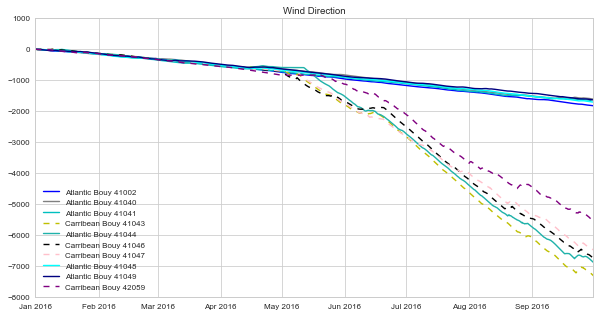

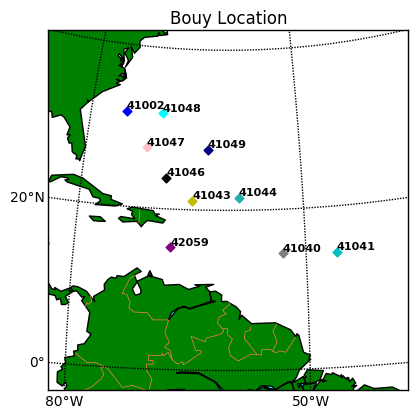

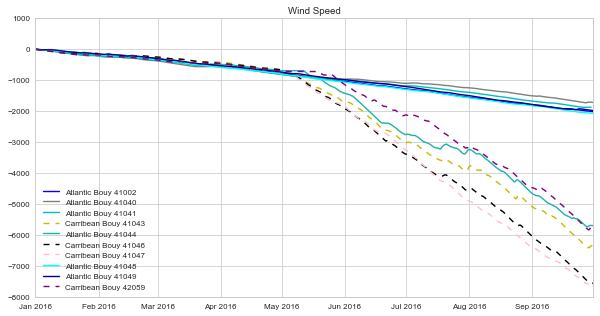

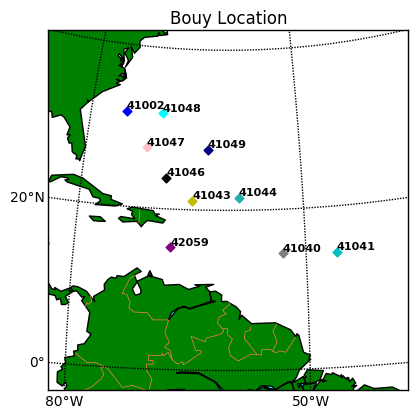

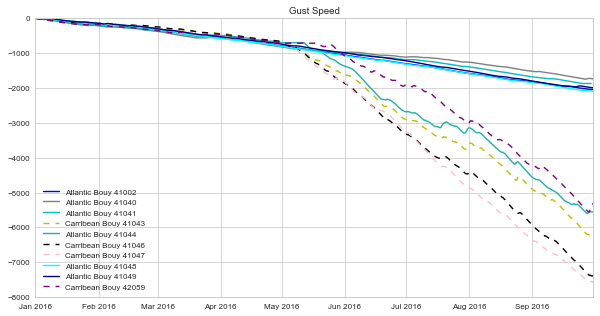

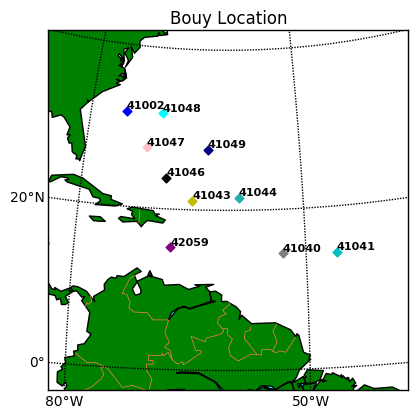

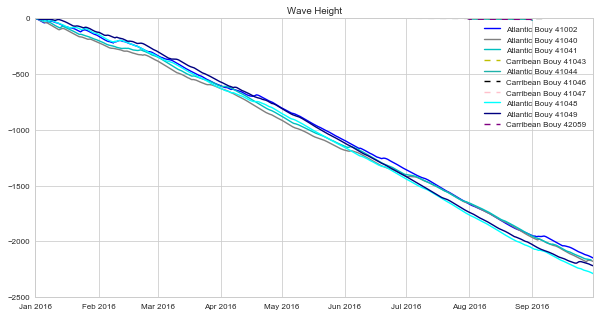

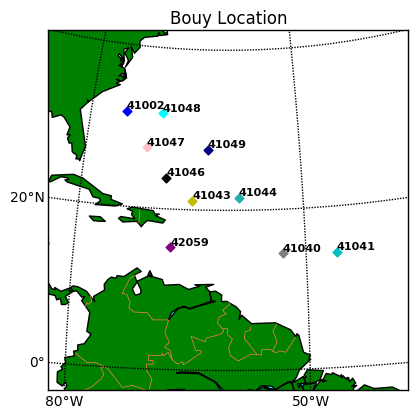

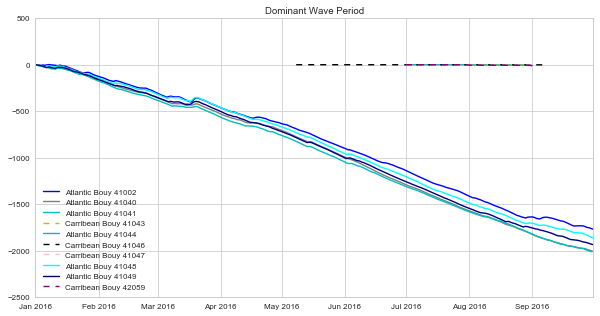

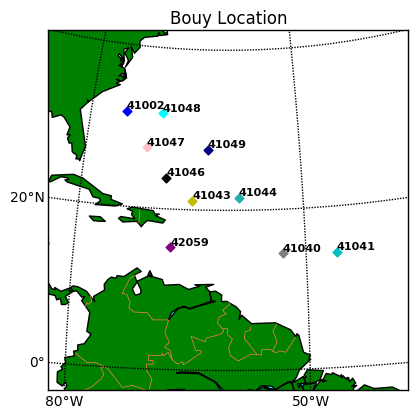

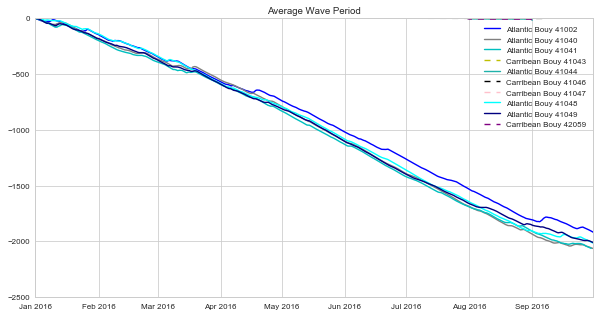

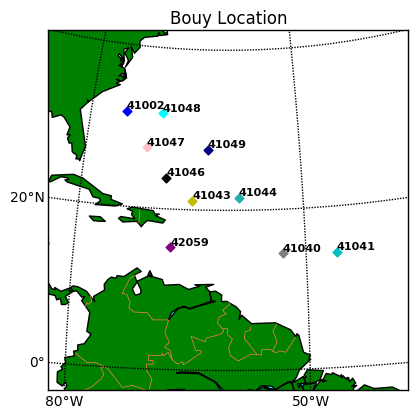

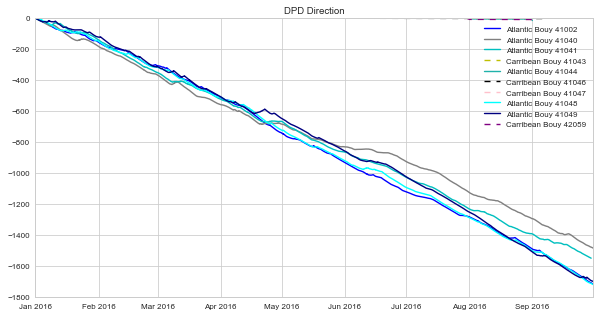

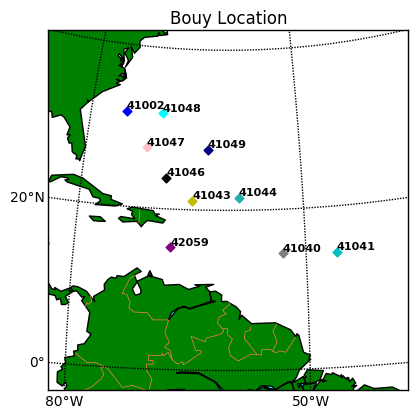

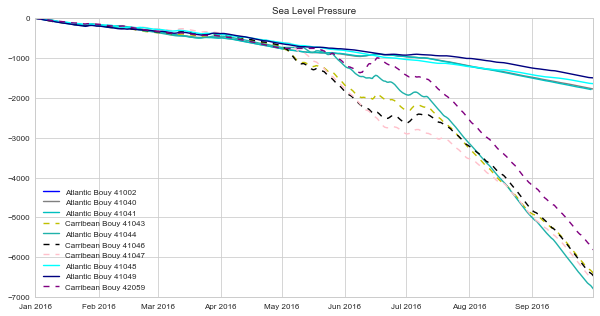

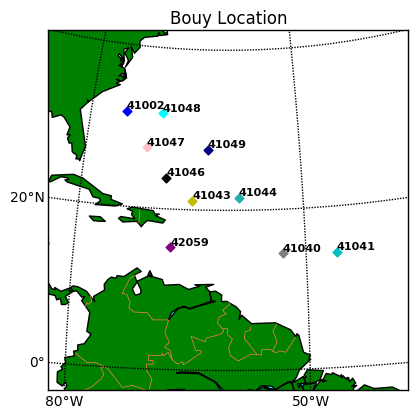

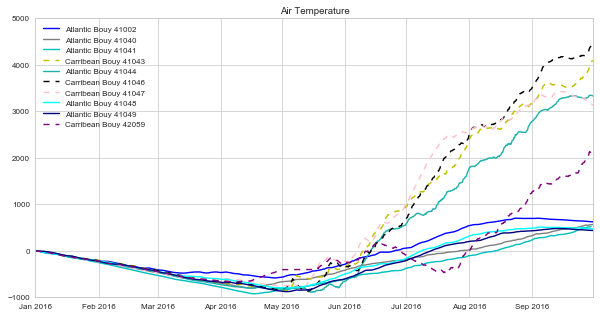

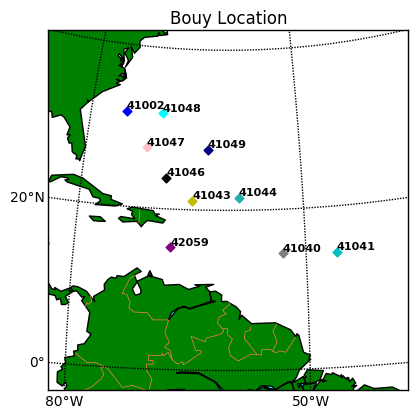

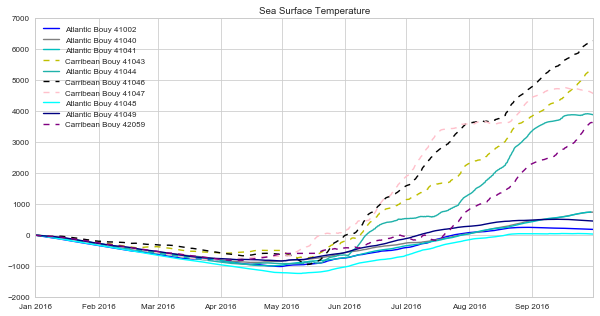

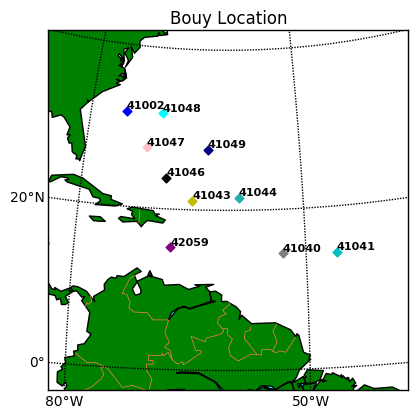

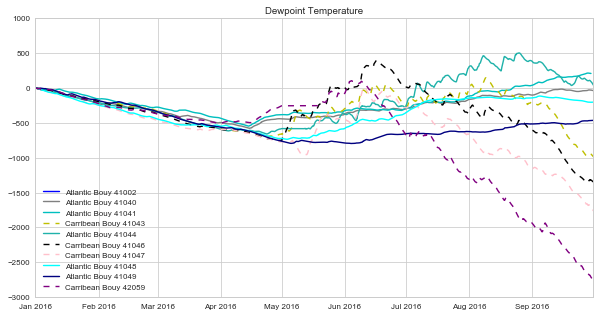

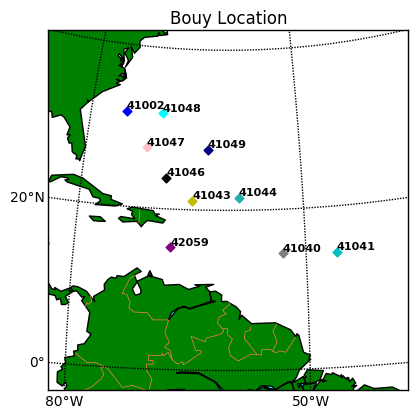

In [65]:
for sensor in all_results['sensor'].unique():
    result = all_results[all_results['sensor'] == sensor]
    plot_mar(result[['sensor', 'value', 'DATETIME', 'ID', 'p_mar']], get_name(sensor))
    display(Image(filename='IMG/Bouy_Loc.png'))